## 7. Accessing the training results

After training completes, a `Result` object is returned which contains information about the training run, including the metrics and checkpoints reported during training.

In [26]:
result

Result(
  metrics={'loss': 0.06367093324661255, 'accuracy': 0.9425080418586731, 'epoch': 1},
  path='/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/ray-summit-2024-training/distributed-mnist-resnet18/TorchTrainer_d89d0_00000_0_2024-11-22_11-49-35/checkpoint_000001)
)

We can check the metrics produced by the training job.

In [27]:
result.metrics_dataframe

,loss,accuracy,epoch,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/num_epochs,config/train_loop_config/global_batch_size
0,0.308870,0.783437,0,1732276209,checkpoint_000000,True,False,1,d89d0_00000,2024-11-22_11-50-09,29.641551,29.641551,30551,ip-10-0-4-138,10.0.4.138,29.641551,1,2,128
1,0.063671,0.942508,1,1732276227,checkpoint_000001,True,False,2,d89d0_00000,2024-11-22_11-50-27,18.365191,48.006742,30551,ip-10-0-4-138,10.0.4.138,48.006742,2,2,128


We can also take the latest checkpoint and load it to inspect the model.

In [28]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model_ray_train = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model_ray_train.load_state_dict(state_dict)
    loaded_model_ray_train.eval()

loaded_model_ray_train

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

To learn more about the training results, see this [docs](https://docs.ray.io/en/latest/train/user-guides/results.html) on inspecting the training results.

We can then proceed to generate predictions using the loaded model:

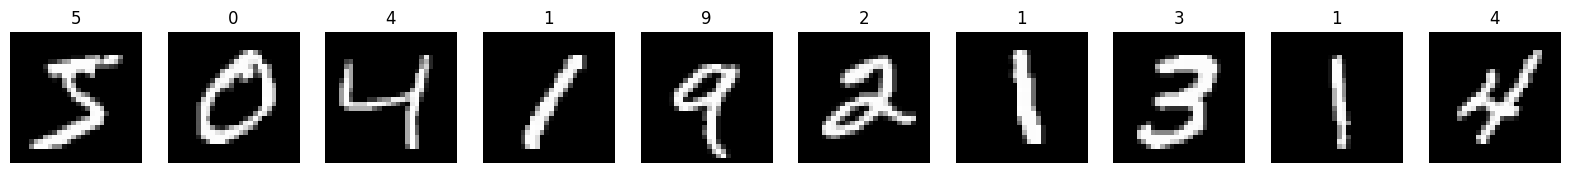

In [31]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    with torch.no_grad():
        normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[i][0]))
        prediction = loaded_model_ray_train(normalized.unsqueeze(0)).argmax()
    axs[i].set_title(prediction.item())
    

<div class="alert alert-block alert-info">

### Activity: Update the training loop to compute the area under the curve of ROC (AUROC)

1. Update the training loop `train_loop_ray_train` to compute the AUROC metric.
2. Update the `print_metrics_ray_train` function to include the AUROC metric.
3. Save the AUROC metric in the `save_checkpoint_and_metrics_ray_train` function.

Use the following code snippets to guide you:

```python
# Hint: Update the print function to include AUROC
def print_metrics_ray_train(...):
    ...

def train_loop_ray_train(config):
    # Hint: Update the training loop to compute AUROC

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
result.metrics_dataframe
```

</div>

In [ ]:
# Write your solution here


<div class="alert alert-block alert-info">

<details>

<summary> Click here to see the solution </summary>

```python
def print_metrics_ray_train(loss, accuracy, auroc):
    metrics = {
        "loss": loss.item(),
        "accuracy": accuracy.item(),
        "auroc": auroc.item(),
    }
    if ray.train.get_context().get_world_rank() == 0:
        print(
            f"Loss: {loss.item()}, Accuracy: {accuracy.item()}, AUROC: {auroc.item()}"
        )
    return metrics


def train_loop_ray_train(config):
    loss_function = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-5)

    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train(batch_size=batch_size)

    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(model.device)
    # Add AUROC metric
    auroc = torchmetrics.AUROC(task="multiclass", num_classes=10).to(model.device)

    for epoch in range(config["num_epochs"]):
        data_loader.sampler.set_epoch(epoch)

        for images, labels in data_loader:
            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc(outputs, labels)
            auroc(outputs, labels)

        metrics = print_metrics_ray_train(
            loss, acc.compute(), auroc.compute()
        )
        save_checkpoint_and_metrics_ray_train(model, metrics)
        acc.reset()
        auroc.reset()

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
print(result.metrics_dataframe)
```

</details>